In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch poutyne

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-8bk0_8mm
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-8bk0_8mm
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.5/213.5 kB 4.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl size=106724 sha256=a431bf842f16d36e3ce773dd02d8019d73d0c217db16b8907348c11689dcd0ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-mrnnu3t9/wheels/1a/49/

In [2]:
from glob import glob
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader,Dataset
import numpy as np
import torchvision
from tqdm import tqdm
import segmentation_models_pytorch as smp
import torch.optim as optim
from torch import nn
from poutyne import Model, ModelCheckpoint, CSVLogger, set_seeds, plot_history,Callback
import wandb, os, poutyne
from pytorch_lightning.loggers import WandbLogger

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
wandb_logger =poutyne.WandBLogger(name="Final_v6", project="Kvasir_Segmentation")
config_dict = {"Optimizer": "adam", "Loss": "Dice-Loss", "lr": 3e-4}
wandb_logger.log_config_params(config_params=config_dict)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [10]:
path='/kaggle/input/kvasirsegmentation/Kvasir-SEG/'
images = sorted(glob(path+"images/*.jpg"))
segs = sorted(glob(path+"masks/*.jpg"))
data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(images, segs)
        ]
print(len(data_dicts))
train_files, val_files=train_test_split(data_dicts,test_size=100,random_state=42)
val_files, test_files=train_test_split(val_files,test_size=50,random_state=42)
len(train_files),len(val_files), len(test_files)


1000


(900, 50, 50)

(528, 622, 3)
255 0


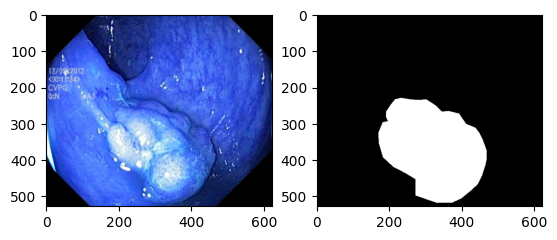

In [11]:
image=cv2.imread(train_files[0]['image'])
mask=cv2.imread(train_files[0]['label'],0)
print(image.shape)
print(mask.max(),mask.min())
fig,ax=plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(mask,cmap='gray')

In [12]:
# 352 https://openaccess.thecvf.com/content/WACV2023/papers/Rahman_Medical_Image_Segmentation_via_Cascaded_Attention_Decoding_WACV_2023_paper.pdf
# We use the combined weighted IoU and weighted BCE loss function --88 IOU
# https://arxiv.org/pdf/2210.04393.pdf 352, AdamW optimizer with initial learning rate of 0.0001
#Our loss function is a combination of Binary Cross Entropy and Dice Loss

In [57]:
imagenet_mean = [0.485, 0.456, 0.406]  # mean of the imagenet dataset for normalizing
imagenet_std = [0.229, 0.224, 0.225]  # std of the imagenet dataset for normalizing

train_aug= A.Compose([ #608
            A.Resize(256, 256, interpolation=cv2.INTER_CUBIC, always_apply=True),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Rotate(10,border_mode=cv2.BORDER_CONSTANT,value=0,mask_value=0), 
            A.RandomCrop(height=256, width=256, p=0.5),
            A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
            ),
            A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
            ),
            A.Normalize(imagenet_mean, imagenet_std),
            ToTensorV2(p=1.0),
        ], p=1.0)

val_aug= A.Compose([
            A.Resize(256, 256),
            A.Normalize(imagenet_mean, std=imagenet_std),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [39]:
class DataReader(Dataset):
    def __init__(self,data,transform=None):
        super(DataReader,self).__init__()
        self.data=data
        self.transform=transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        image_path=self.data[index]['image']
        mask_path=self.data[index]['label']

        image=cv2.imread(image_path)
        mask=cv2.imread(mask_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY )
        if self.transform:
            transformed =self.transform(image=image,mask=mask)
            image=transformed['image']
            mask=transformed['mask']
            mask=np.expand_dims(mask,0)/255.0
#             print(mask)

        return image,mask

In [40]:
ds = DataReader(data=data_dicts, transform=train_aug)
loader=DataLoader(ds, batch_size=8, shuffle=True,num_workers=4)
batch=  next(iter(loader))  
print(batch[0].shape,batch[1].shape)
print(batch[1].max(),batch[1].min())

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)


Text(0.5, 1.0, 'batch of masks')

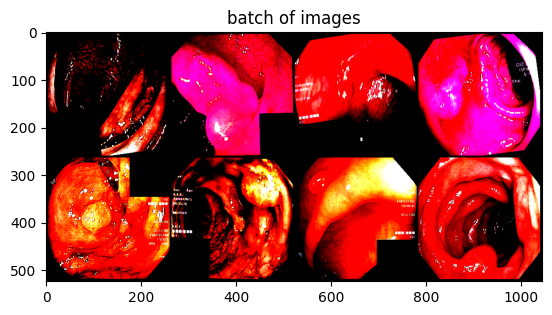

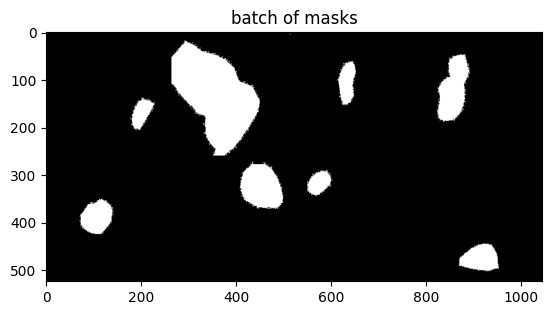

In [41]:
plt.figure()
grid_img=torchvision.utils.make_grid(batch[0],4,4)
plt.imshow(grid_img.permute(1, 2, 0))
plt.title('batch of images')
plt.figure()
grid_img=torchvision.utils.make_grid(batch[1],4,4)
plt.imshow(grid_img.permute(1, 2, 0)*255)
plt.title('batch of masks')

In [56]:
batch_size=16
numworker=2
def train_dataloader():
    ds = DataReader(data=train_files, transform=train_aug)
    loader=DataLoader(ds, batch_size=batch_size, shuffle=True,num_workers=numworker,drop_last=True)
    return loader
def val_dataloader():
    ds = DataReader(data=val_files, transform=val_aug)
    loader=DataLoader(ds, batch_size=batch_size, shuffle=False,num_workers=numworker)
    return loader
def test_loader():
    ds = DataReader(data=test_files, transform=val_aug)
    loader=DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=numworker)
    return loader

In [47]:
network = smp.create_model(
            "unetplusplus", encoder_name="resnet101", encoder_depth=5,encoder_weights='imagenet',decoder_channels=(256, 128, 64, 32, 16),decoder_use_batchnorm=True, in_channels=3, classes=1, activation="sigmoid"
        )

In [58]:
from segmentation_models_pytorch.utils.metrics import IoU
import torch
Iou_result=IoU(threshold=0.5)
loss=smp.losses.DiceLoss('binary', from_logits=False)
lr=3e-4
# optimizer=torch.optim.AdamW(network.parameters(), lr=lr,weight_decay=1e-5)
optimizer = optim.Adam(network.parameters(), lr=lr)

In [59]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Model(
    network,
    optimizer,
    loss,
    batch_metrics=[Iou_result],
    epoch_metrics=[Iou_result],
    device="all",
)

In [21]:
#### Callback
checkpoint_dir = "/kaggle/working/models/"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, "model_checkpoint_{epoch:02d}.pth")
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    mode="min",          
    save_best_only=False,
    verbose=True
)
csv_logger = CSVLogger(os.path.join(checkpoint_dir, 'log.tsv'), separator='\t')

In [22]:
best_iou = 0.0
best_epoch = -1
best_loss = float('inf')
# wandb.init(name="OnnX_Pretrained", project="DogVsCatClassification")
class WandBEpochCallback(Callback):
    def __init__(self):
        super().__init__()
        self.best_accuracy = 0.0
        self.best_epoch = -1
        self.best_loss = float('inf')
    
    def on_epoch_end(self, epoch, logs):
        # Log metrics to WandB for each epoch
        wandb.log({"epoch": epoch + 1,
                   "train_loss": logs['loss'],
                   "dice_coefficient1": 1-logs['loss'],
                   "train_iou_score": logs['iou_score1'],
                   "val_iou_score": logs['val_iou_score1'],
                   "val_loss": logs['val_loss']})
        # Track best accuracy, best epoch, and best loss
        if logs['val_iou_score1'] > self.best_accuracy:
            self.best_iou = logs['val_iou_score1']
            self.best_epoch = epoch + 1
        
        if logs['val_loss'] < self.best_loss:
            self.best_loss = logs['val_loss']

        # Log best accuracy, best epoch, and best loss
        wandb.log({"val_iou_score": self.best_iou,
                   "best_epoch": self.best_epoch,
                   "best_loss": self.best_loss})
        
        # Calculate epoch/accuracy and epoch/learning_rate ratios
        epoch_learning_rate_ratio = (epoch + 1) / optimizer.param_groups[0]['lr']
        
        # Log epoch/accuracy and epoch/learning_rate ratios
        wandb.log({"epoch_learning_rate_ratio": epoch_learning_rate_ratio})
wandbcallback=WandBEpochCallback()

In [26]:
history=model.fit_generator(train_dataloader(), val_dataloader(), epochs=60,callbacks=[checkpoint_callback, csv_logger, wandbcallback])

Epoch:  1/60 Train steps: 56 Val steps: 4 45.48s loss: 0.305674 iou_score1: 0.650104 iou_score2: 0.650104 val_loss: 0.334678 val_iou_score1: 0.573119 val_iou_score2: 0.573119
Epoch 1: saving file to /kaggle/working/models/model_checkpoint_01.pth
Epoch:  2/60 Train steps: 56 Val steps: 4 45.30s loss: 0.259765 iou_score1: 0.669735 iou_score2: 0.669735 val_loss: 0.367555 val_iou_score1: 0.510068 val_iou_score2: 0.510068
Epoch 2: saving file to /kaggle/working/models/model_checkpoint_02.pth
Epoch:  3/60 Train steps: 56 Val steps: 4 45.75s loss: 0.247596 iou_score1: 0.656348 iou_score2: 0.656348 val_loss: 0.286410 val_iou_score1: 0.591227 val_iou_score2: 0.591227
Epoch 3: saving file to /kaggle/working/models/model_checkpoint_03.pth
Epoch:  4/60 Train steps: 56 Val steps: 4 46.01s loss: 0.214120 iou_score1: 0.690584 iou_score2: 0.690584 val_loss: 0.253507 val_iou_score1: 0.628509 val_iou_score2: 0.628509
Epoch 4: saving file to /kaggle/working/models/model_checkpoint_04.pth
Epoch:  5/60 Tra

[{'epoch': 1,
  'time': 45.484616233999986,
  'loss': 0.30567441174858495,
  'iou_score1': 0.6501043423004155,
  'iou_score2': 0.6501043423004155,
  'val_loss': 0.3346782875061035,
  'val_iou_score1': 0.5731187215156914,
  'val_iou_score2': 0.5731187215156914},
 {'epoch': 2,
  'time': 45.29659165500016,
  'loss': 0.25976466068199705,
  'iou_score1': 0.6697352290284497,
  'iou_score2': 0.6697352290284497,
  'val_loss': 0.3675553894042969,
  'val_iou_score1': 0.5100675609092037,
  'val_iou_score2': 0.5100675609092037},
 {'epoch': 3,
  'time': 45.752748182000005,
  'loss': 0.2475962255682264,
  'iou_score1': 0.6563475803384929,
  'iou_score2': 0.6563475803384929,
  'val_loss': 0.28640985012054443,
  'val_iou_score1': 0.5912266531081447,
  'val_iou_score2': 0.5912266531081447},
 {'epoch': 4,
  'time': 46.008380902,
  'loss': 0.21411992183753423,
  'iou_score1': 0.6905840625982399,
  'iou_score2': 0.6905840625982399,
  'val_loss': 0.2535069012641907,
  'val_iou_score1': 0.6285093313028671,


In [72]:
import pandas as pd 
logs =pd.read_csv("/kaggle/working/models/log.tsv", sep='\t')
epochs = logs['epoch']
val_loss = logs['loss']
loss = logs['val_loss']

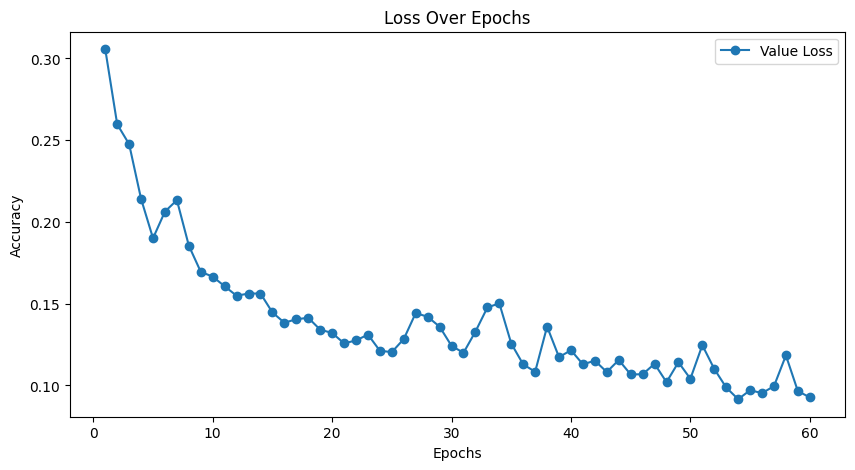

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, label='Value Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Loss Over Epochs')
plt.legend()

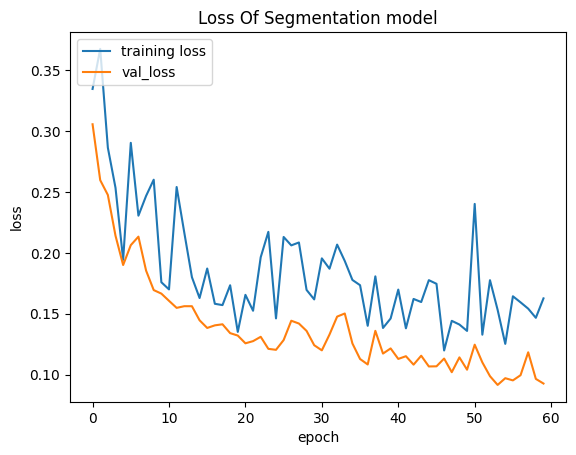

In [43]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss Of Segmentation model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'val_loss'], loc='upper left')
plt.show()

In [76]:
#find out the best model
lowest_loss_index = np.argmin(logs['val_loss'])
lowest_loss_index + 1 

47

In [60]:
#### Import best model with Lowest value loss
model = Model(
    network,
    optimizer,
    loss,
    batch_metrics=[Iou_result],
    epoch_metrics=[Iou_result],
    device="all",
)
model.load_weights("/kaggle/input/kvasir-semantic-segmentation/models/model_checkpoint_47.pth")
loss,dice_coefficient=model.evaluate_generator(test_loader())

Test steps: 4 1.82s test_loss: 0.119779 test_iou_score1: 0.787586 test_iou_score2: 0.787586           


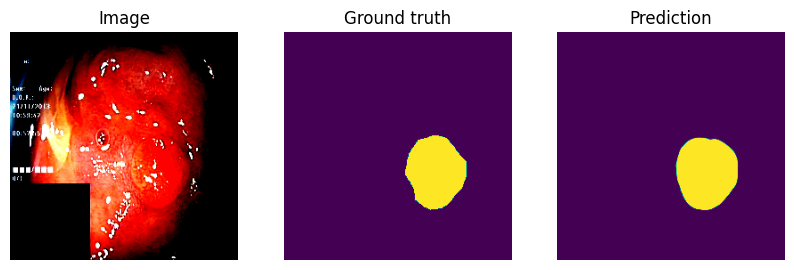

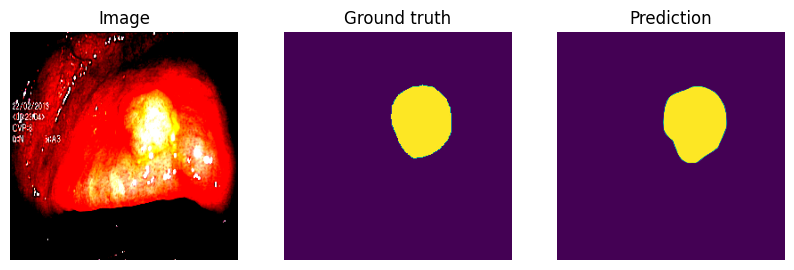

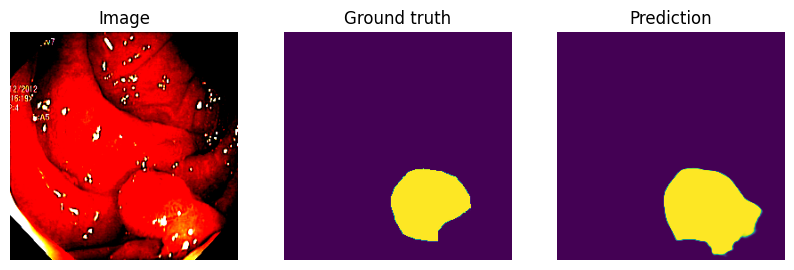

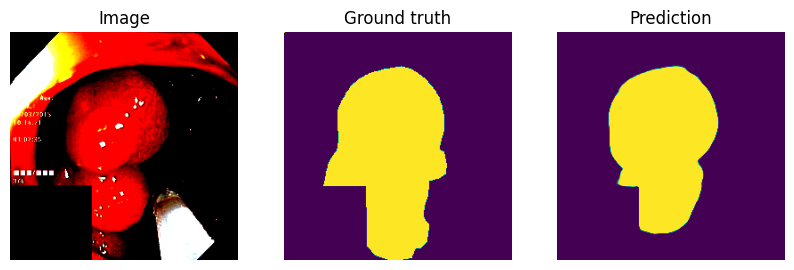

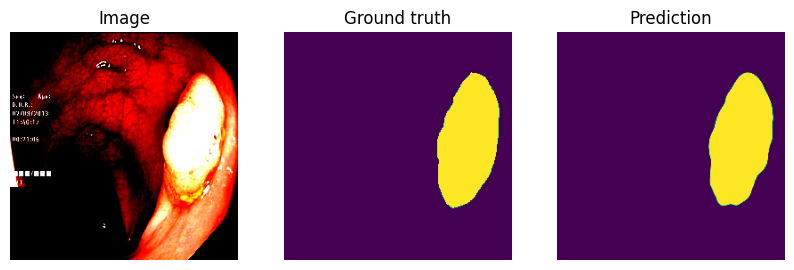

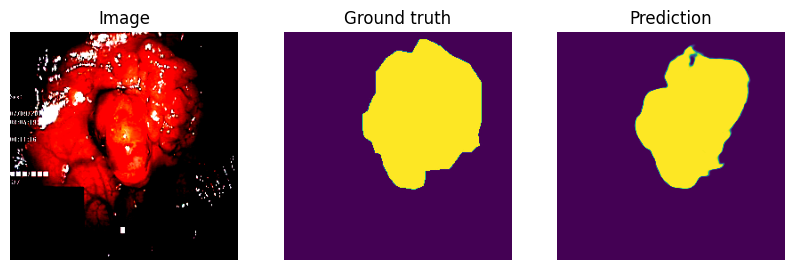

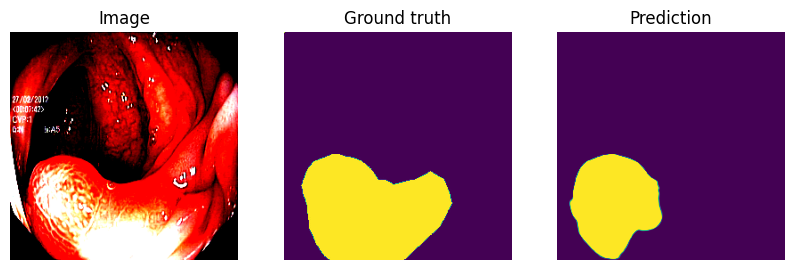

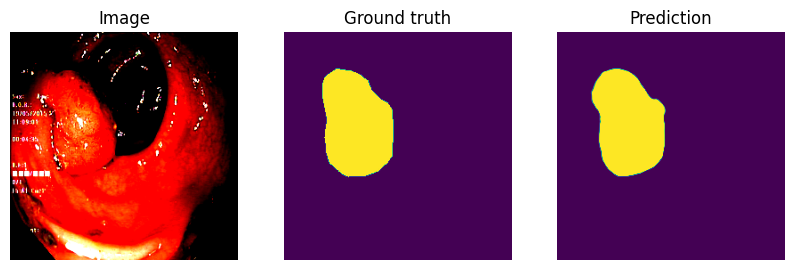

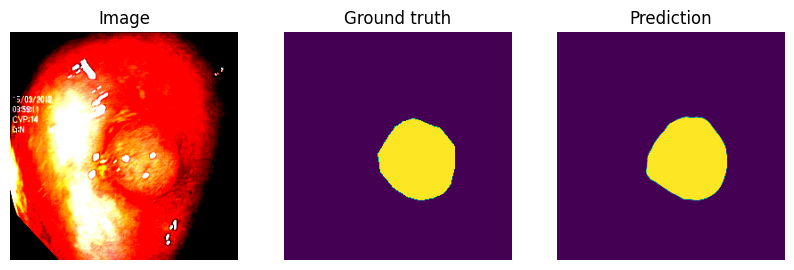

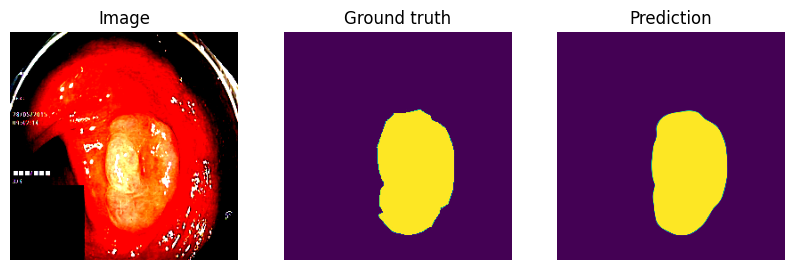

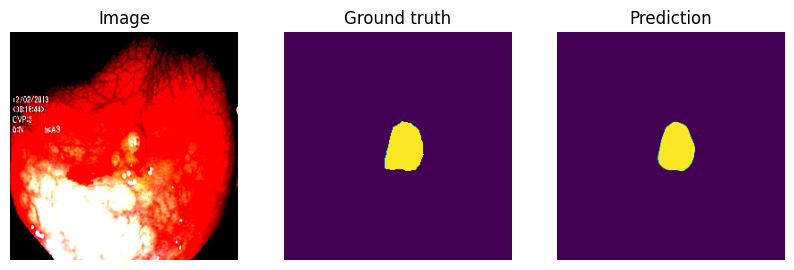

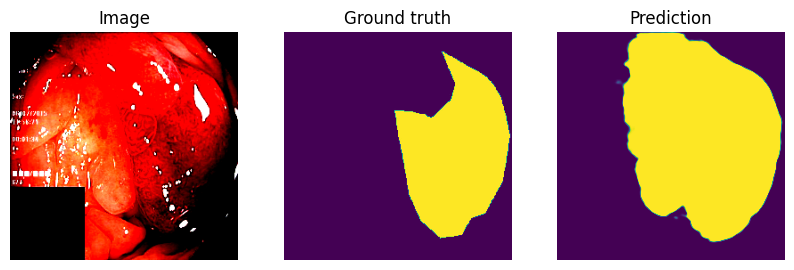

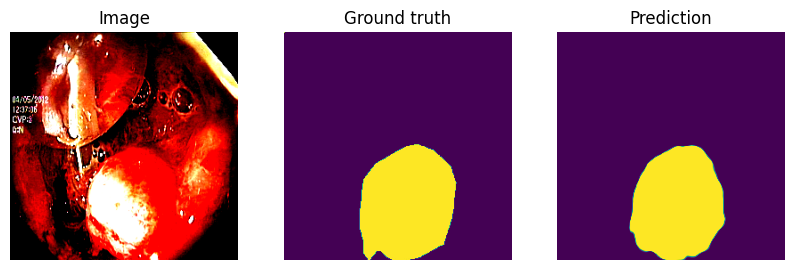

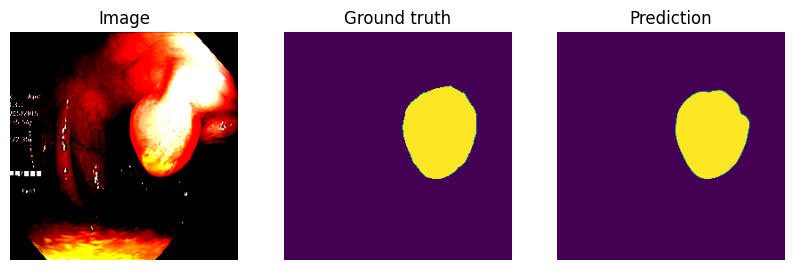

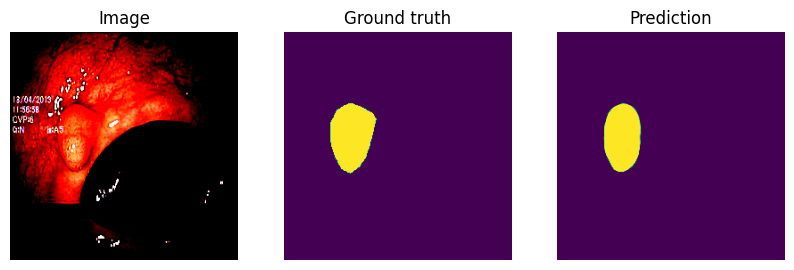

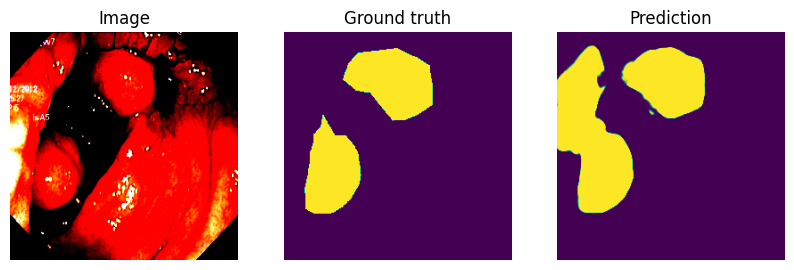

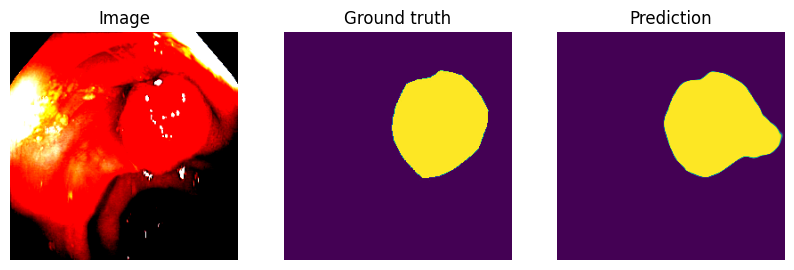

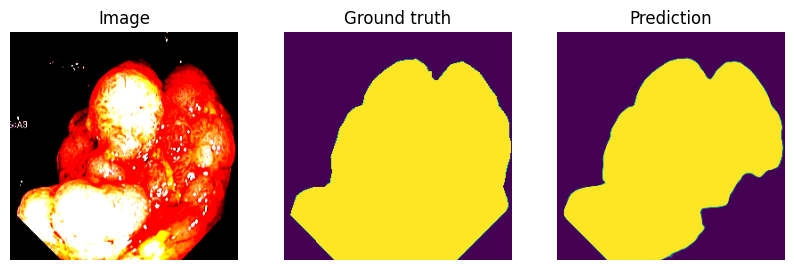

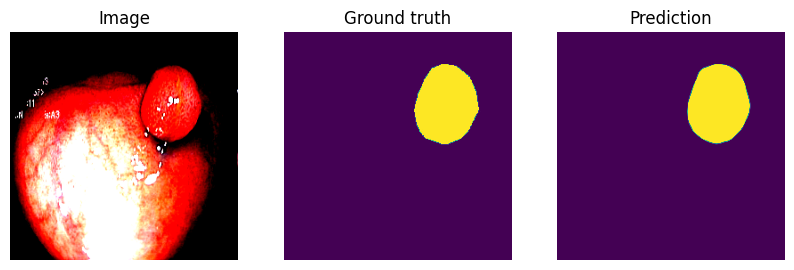

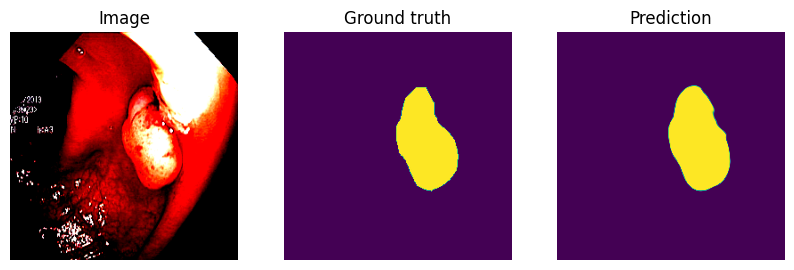

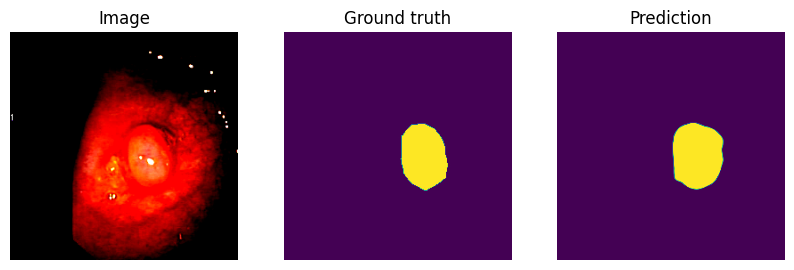

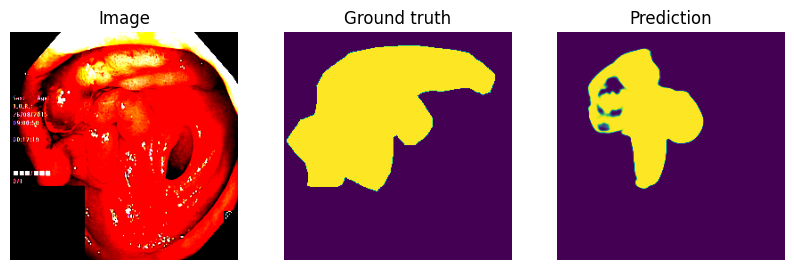

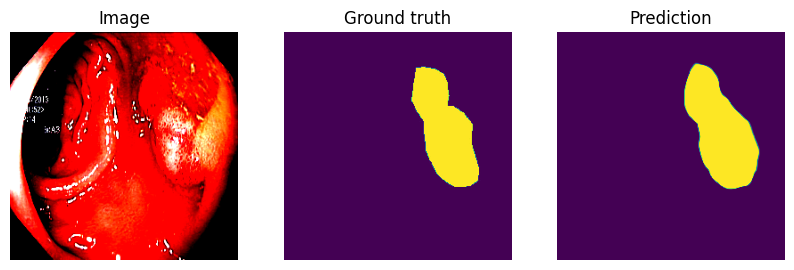

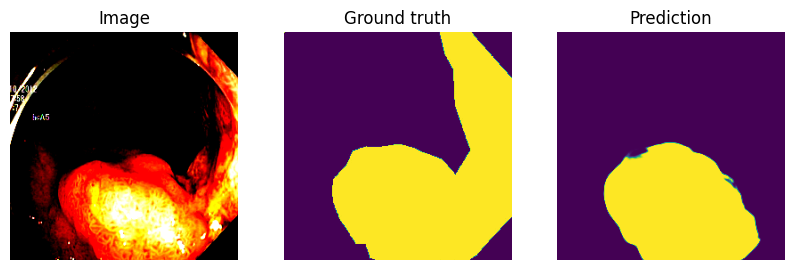

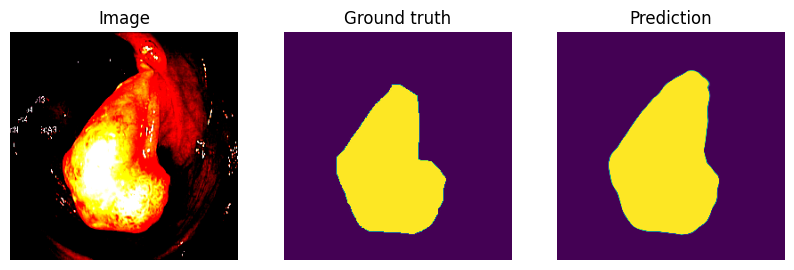

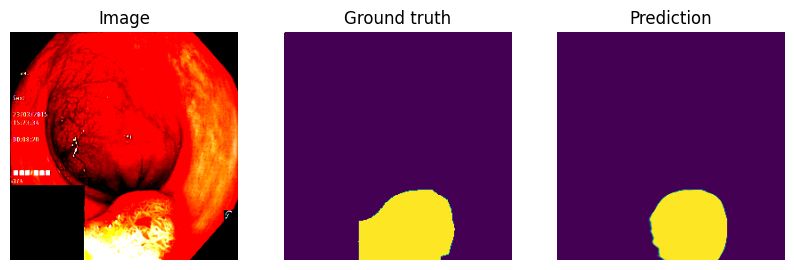

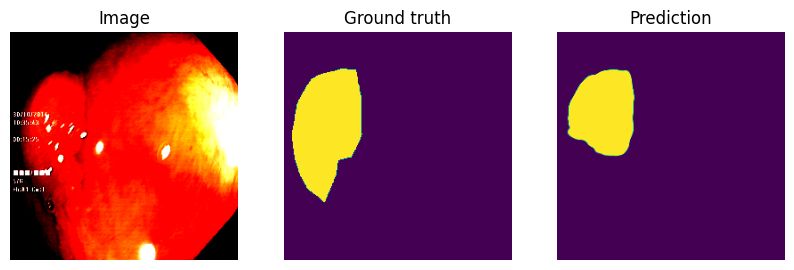

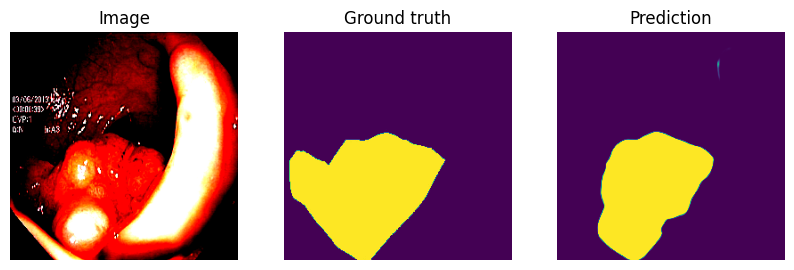

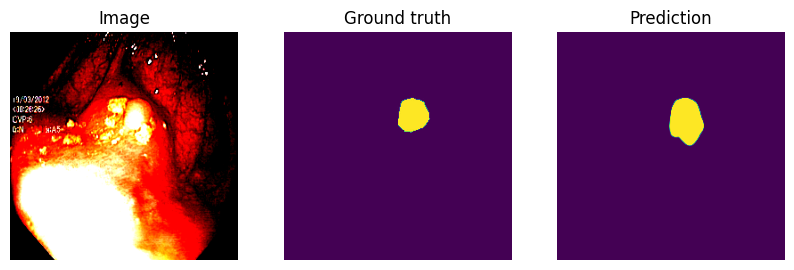

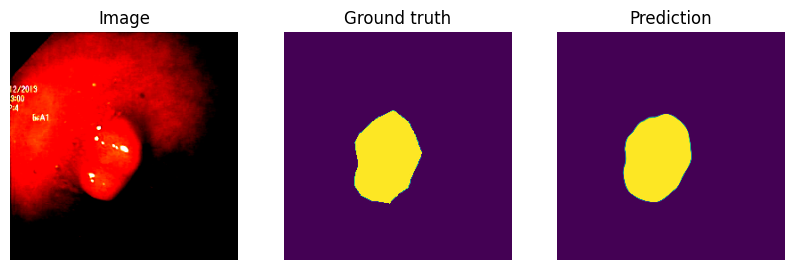

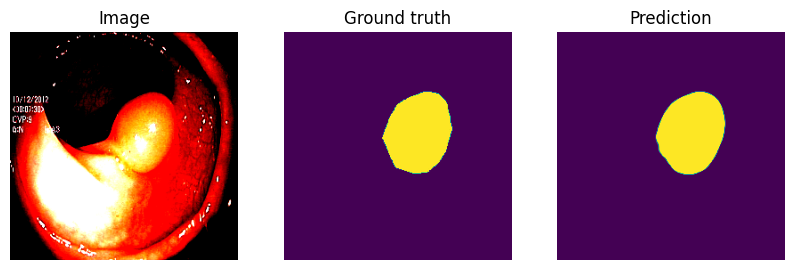

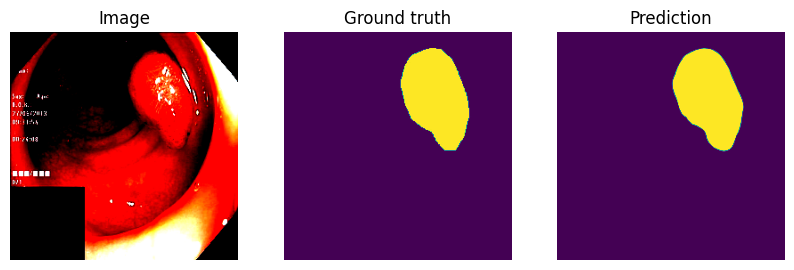

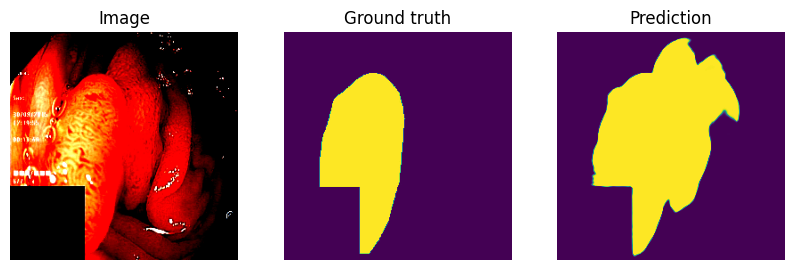

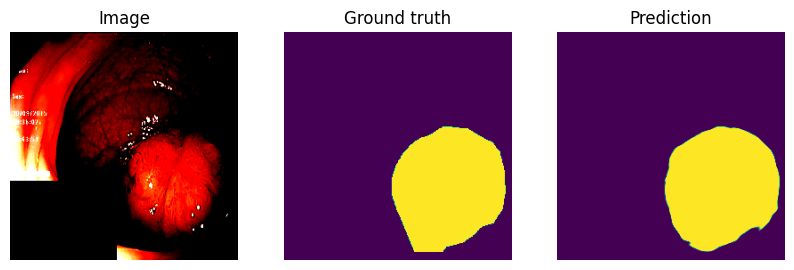

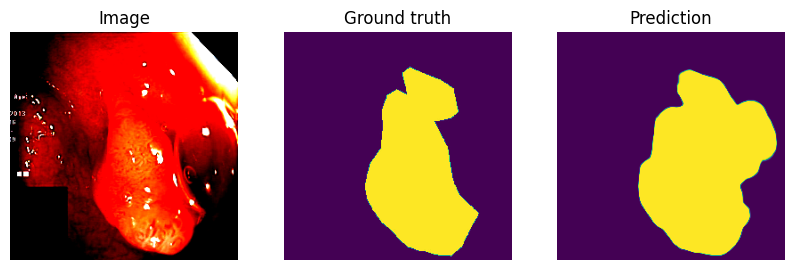

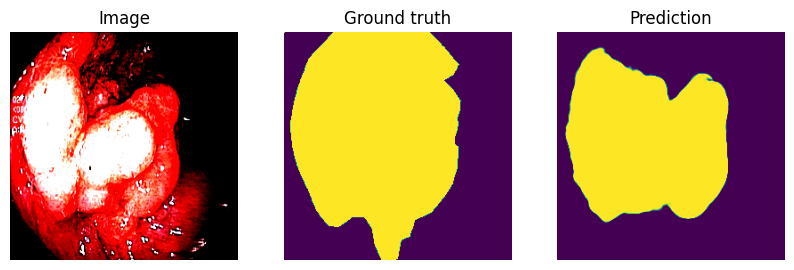

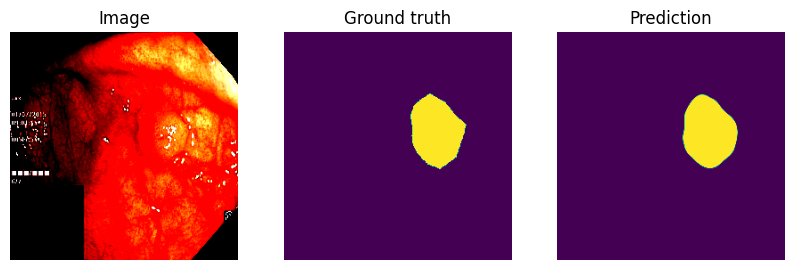

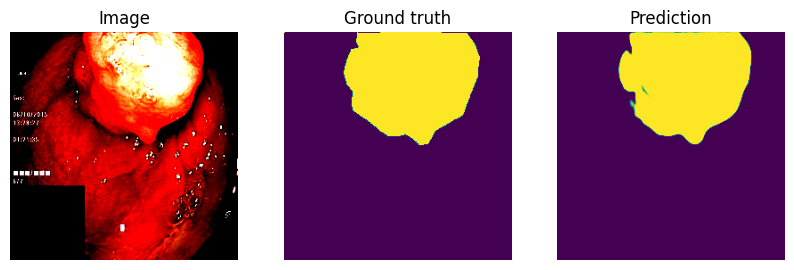

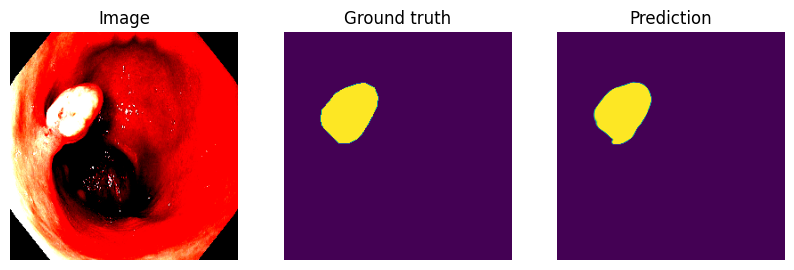

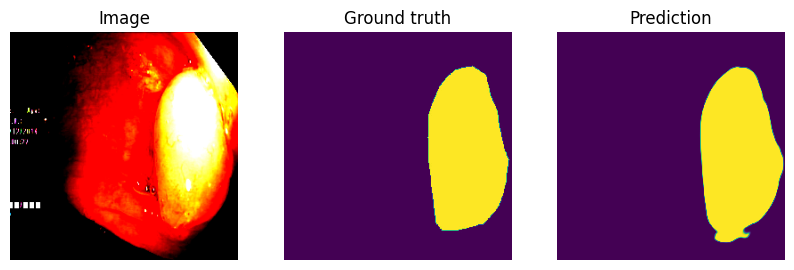

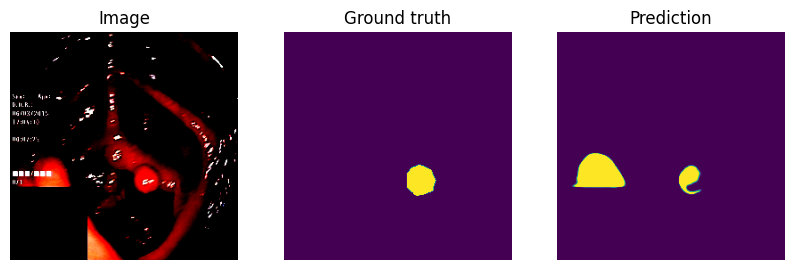

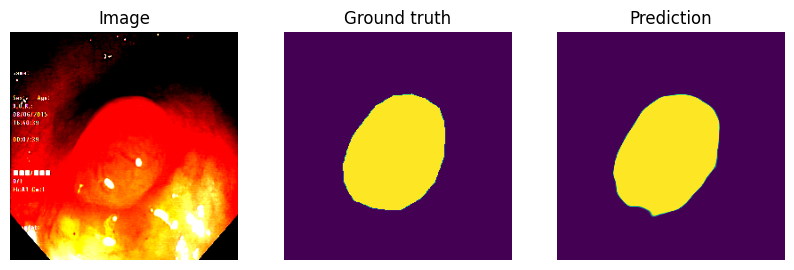

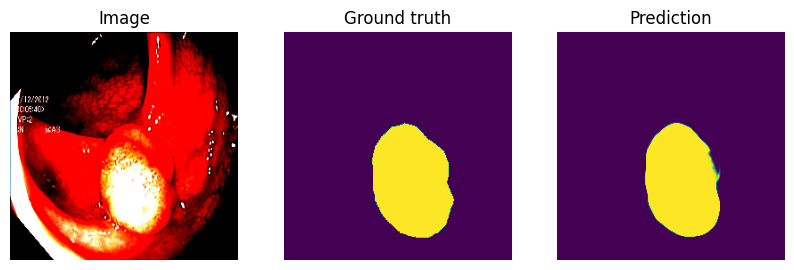

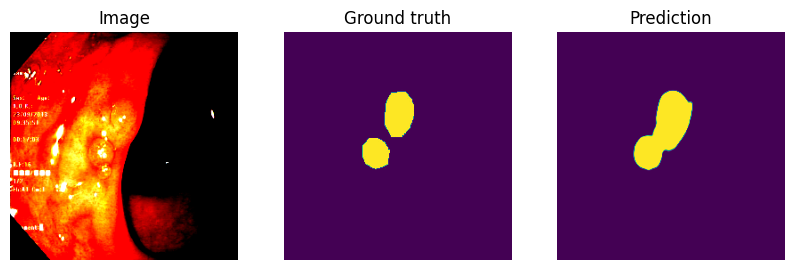

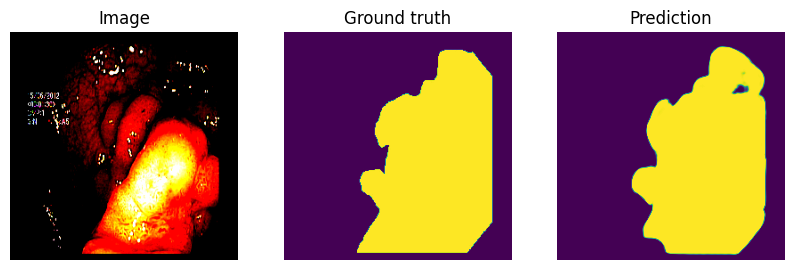

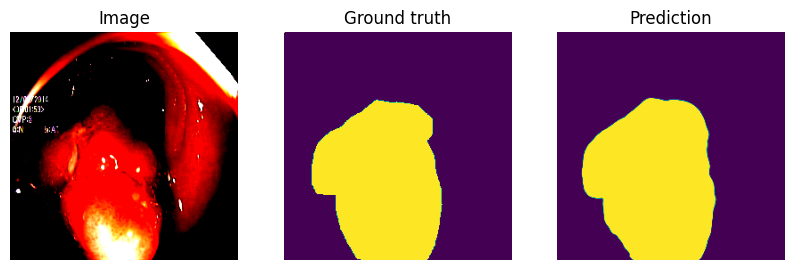

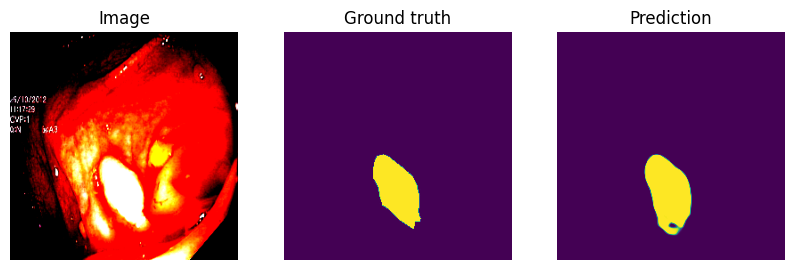

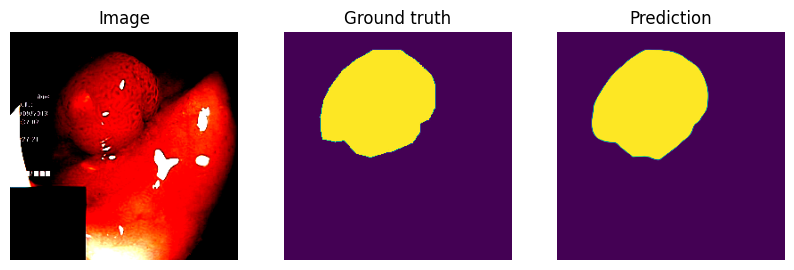

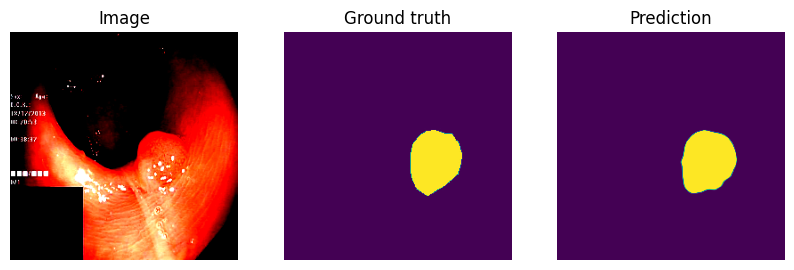

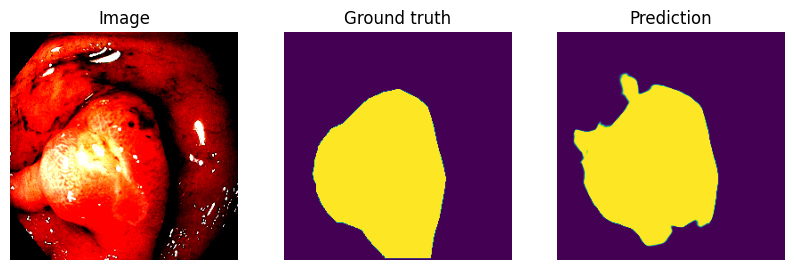

In [61]:
# Define a function to visualize predictions
def visualize_predictions(inputs, ground_truths, predictions):
    for input_img, gt_mask, pr_mask in zip(inputs, ground_truths, predictions):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(input_img.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.squeeze(0)) # just squeeze classes dim, because we have only one class
        plt.title("Prediction")
        plt.axis("off")

        plt.show()
        
# inputs, ground_truths = next(iter(test_loader()))
for inputs, ground_truths in test_loader():
    outputs = model.predict_on_batch(inputs)
    visualize_predictions(inputs, ground_truths, outputs)

In [84]:
wandb.finish()

### Working Flow on Segmentation

Segmentation is on of the popular invention of Deep Learning and this can apply too many areas on real life. In this section will discuss and apply pixel wise segmentation on the dataset of Kvasir Seg.

#### Dataset
It is an open-access dataset of gastrointestinal polyp images and corresponding segmentation masks, manually annotated and verified by an experienced gastroenterologist. There is 1000 polyp images with mask as ground Truth and also mention about the resolution of the dataset is 332x482 to 1920x1072 pixels.Those image files are encoded using JPEG compression. The dataset also have bounding box to identified the polyp on images.

#### EDA and Augmentation

On EDA section check several like check image size and mask size and identified big mask and Image length. Then try to preprocess dataset for model.Firstly, import dataset as image and mask then make dictionary to divided mask and image together for train, test and validation. In the task already mentioned that tran images size will be 900 and 50 , 50 for the validation and testing.

After dividing those images now apply augmentation on each part for betterment of the model.For three section create 2 augmentation path using Albumentation. In training part apply several flip and rotation with resize those images as a fixed size. On test and validation section apply same technique like resize and normalization.


#### Pytorch Segmentation model
Very popular and effective library for segmentation. Pytorch segmentation have different type of architecture and encoder as well as pretrained weights. Have difference types of parameter to chosing design of architecture and encoder skteps. In architecture section I chose Unet++ for my dataset and a encoder with resnet101 encoder. Adam optimizer with learning rate 0.0003 which is best for Adam.

#### Metrics and loss
In terms of loss and metrics segmentation model is difference from other traditional model. In segmentation most popular metrics is IOU(intersection over Union) and difference types of loss like focal loss, diceloss and so on. In this task mentioned to chose IOU and Dice Loss to apply this model. Besides that I also try to find out Dice-efficiency from DiceLoss. In can be calculate like 1-DiceLoss which is 0.90729 from my test dataset.

#### Result : 

In segmentation, Basically model try to classify each pixel and predict the result so Augmentation and preprocessing played very crucial part on that. I tried several augmentation and resizing paert from the libary Albumentations.Which is one of the best and very nicely present with torch. Trine 60 epoch using multiple GPU on Kaggle and got best val_loss on 47 epoch among 60. Then try to load that weight and predict the result from the test loader.

| Val_Loss|Dice_eff |Iou_training |IOU testing|
| ----- | ----- |-----|---------|
|0.11985| 0.90729|0.83299|0.787586|


#### Conclusion
Faced several dificulties like preprocess Image together and how to do fit the model together like mask and images. In this section Albumentatios helps, Thanks to Albumentatios. Then another way faced on reducing loss on Dice Loss, Technically diceloss have from_logits is True and I also used sigmoid as my activation function then it collaps with loss. Then my reporting boss tell me to check that and I find that error and use as from_logits=False on DiceLoss and model do well and both side. Loats of Improvement left like more EDA on Pixel wise and find perfect formate to find feed the data to model.